In [1]:
import os
import json
import itertools
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Librerias pra procesamiento del texto
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')

# Librerias de sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Librerias de Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from joblib import dump, load

from scikeras.wrappers import KerasClassifier


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cargando base de datos

In [2]:
def load_jsonlines(filepath):
    # Carga un archivo .jsonlines como un DataFrame de Pandas
    data = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df

# Ruta al archivo .jsonlines
filepath = '../data/MLA_100k_checked_v3.jsonlines'

# Cargar los datos
df = load_jsonlines(filepath)

In [3]:
df.columns

Index(['seller_address', 'warranty', 'sub_status', 'condition', 'deal_ids',
       'base_price', 'shipping', 'non_mercado_pago_payment_methods',
       'seller_id', 'variations', 'site_id', 'listing_type_id', 'price',
       'attributes', 'buying_mode', 'tags', 'listing_source', 'parent_item_id',
       'coverage_areas', 'category_id', 'descriptions', 'last_updated',
       'international_delivery_mode', 'pictures', 'id', 'official_store_id',
       'differential_pricing', 'accepts_mercadopago', 'original_price',
       'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created',
       'secure_thumbnail', 'stop_time', 'status', 'video_id',
       'catalog_product_id', 'subtitle', 'initial_quantity', 'start_time',
       'permalink', 'sold_quantity', 'available_quantity'],
      dtype='object')

In [4]:
df.head()

,seller_address,warranty,sub_status,condition,deal_ids,base_price,shipping,non_mercado_pago_payment_methods,seller_id,variations,...,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity
0,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],new,[],80.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8208882349,[],...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1
1,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NUESTRA REPUTACION,[],used,[],2650.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8141699488,[],...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1
2,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],used,[],60.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8386096505,[],...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1
3,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],new,[],580.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",5377752182,[],...,1449191596000,active,None,NaN,None,1,1443466076000,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1
4,"{'country': {'name': 'Argentina', 'id': 'AR'},...",MI REPUTACION.,[],used,[],30.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",2938071313,[],...,1445638040000,active,None,NaN,None,1,1440454040000,http://articulo.mercadolibre.com.ar/MLA7787961...,0,1


# Análisis de la Variable Objetivo

## Balance de Clases en `condition`

En este análisis preliminar, nuestro objetivo es evaluar cómo se distribuyen las clases dentro de nuestra variable objetivo `condition`, la cual indica si un artículo del dataset de MercadoLibre es nuevo o usado. Entender esta distribución es crucial para diseñar nuestro modelo de machine learning, ya que un desbalance significativo podría afectar la capacidad del modelo para aprender de ambas clases eficientemente.

### Distribución de `condition`

Después de revisar el dataset, hemos encontrado la siguiente distribución para la variable objetivo `condition`:

- **Nuevos (`new`):** 53.758 - 53,8%
- **Usados (`used`):** 46,242 - 46,2%



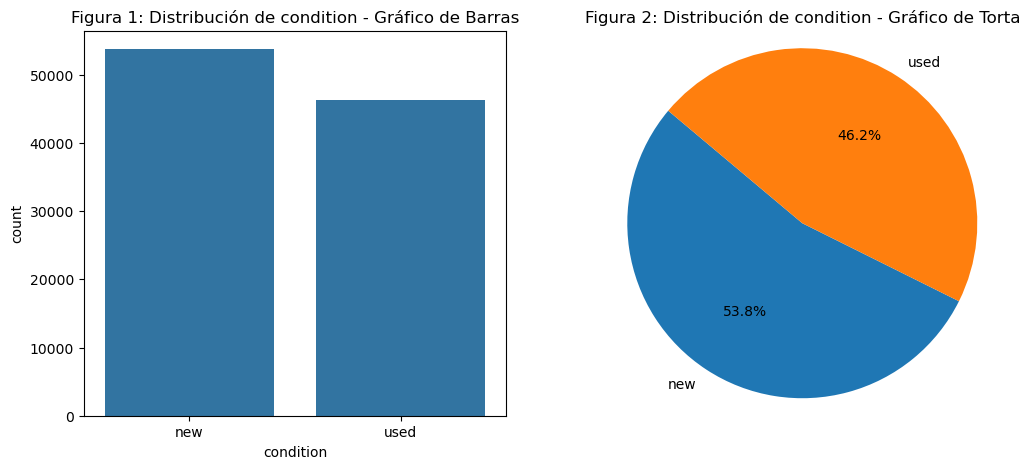

condition
new     53758
used    46242
Name: count, dtype: int64

In [5]:
# Configuramos una figura que contendrá ambos gráficos
plt.figure(figsize=(12, 5))

# Gráfico de barras
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
sns.countplot(x='condition', data=df)
plt.title('Figura 1: Distribución de condition - Gráfico de Barras')

# Gráfico de torta
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2

# Calculamos las frecuencias de cada categoría en 'condition'
condition_counts = df['condition'].value_counts()

# Creamos el gráfico de torta
plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Figura 2: Distribución de condition - Gráfico de Torta')
plt.axis('equal')  # Esto asegura que se dibuje un círculo.

# Mostramos ambos gráficos
plt.show()
condition_counts

## Análisis Preliminar: Gestión de Valores Faltantes

Durante la fase inicial de nuestro análisis de datos, hicimos un descubrimiento crucial relacionado con la prevalencia de valores faltantes en el conjunto de datos. Aquí resumimos nuestros hallazgos y las acciones subsiguientes que hemos decidido tomar:

- **Observación General**: Una revisión detallada reveló que todas las filas del conjunto de datos contienen al menos un valor faltante en alguna columna. Este patrón general sugiere una necesidad significativa de limpieza y preprocesamiento de datos.

- **Análisis Específico de Columnas**:
    - Identificamos varias columnas con una alta incidencia de valores faltantes, destacándose `differential_pricing` y `subtitle`, que están completamente vacías en todo el conjunto de datos.
    - Las columnas `catalog_product_id`, `original_price`, `official_store_id`, y `video_id` presentan valores faltantes en más del 97% de las filas, lo que indica que su inclusión podría introducir ruido más que valor.
    - Por otro lado, `warranty` y `parent_item_id` muestran una presencia más moderada de valores faltantes, lo que justifica una evaluación adicional para determinar su relevancia en nuestro análisis.

- **Decisiones de Limpieza**:
    - Basándonos en este análisis, hemos decidido eliminar las siguientes columnas por su falta de contribución significativa y la alta prevalencia de valores faltantes:
        - `differential_pricing`
        - `subtitle`
        - `catalog_product_id`
        - `original_price`
        - `official_store_id`
        - `video_id`
    - **En Observación**:
        - Optamos por mantener `warranty` y `parent_item_id` bajo observación para una evaluación más detallada. Nuestro objetivo es determinar si su inclusión puede ofrecer insights valiosos para predecir si un producto es nuevo o usado, sin comprometer la calidad del modelo.

Este enfoque selectivo hacia la gestión de valores faltantes nos permite refinar nuestro conjunto de datos, manteniendo solo aquellas características que tienen el potencial de mejorar la precisión y la generalización de nuestros modelos predictivos.


total de NaNs: 679950
total de filas con NaNs: 100000


/tmp/ipykernel_23059/2744186684.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_k_nan_columnas.index, y=top_k_nan_columnas.values, palette='viridis', ax=ax[1])
/tmp/ipykernel_23059/2744186684.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(top_k_nan_columnas.index, rotation=45, ha='right')


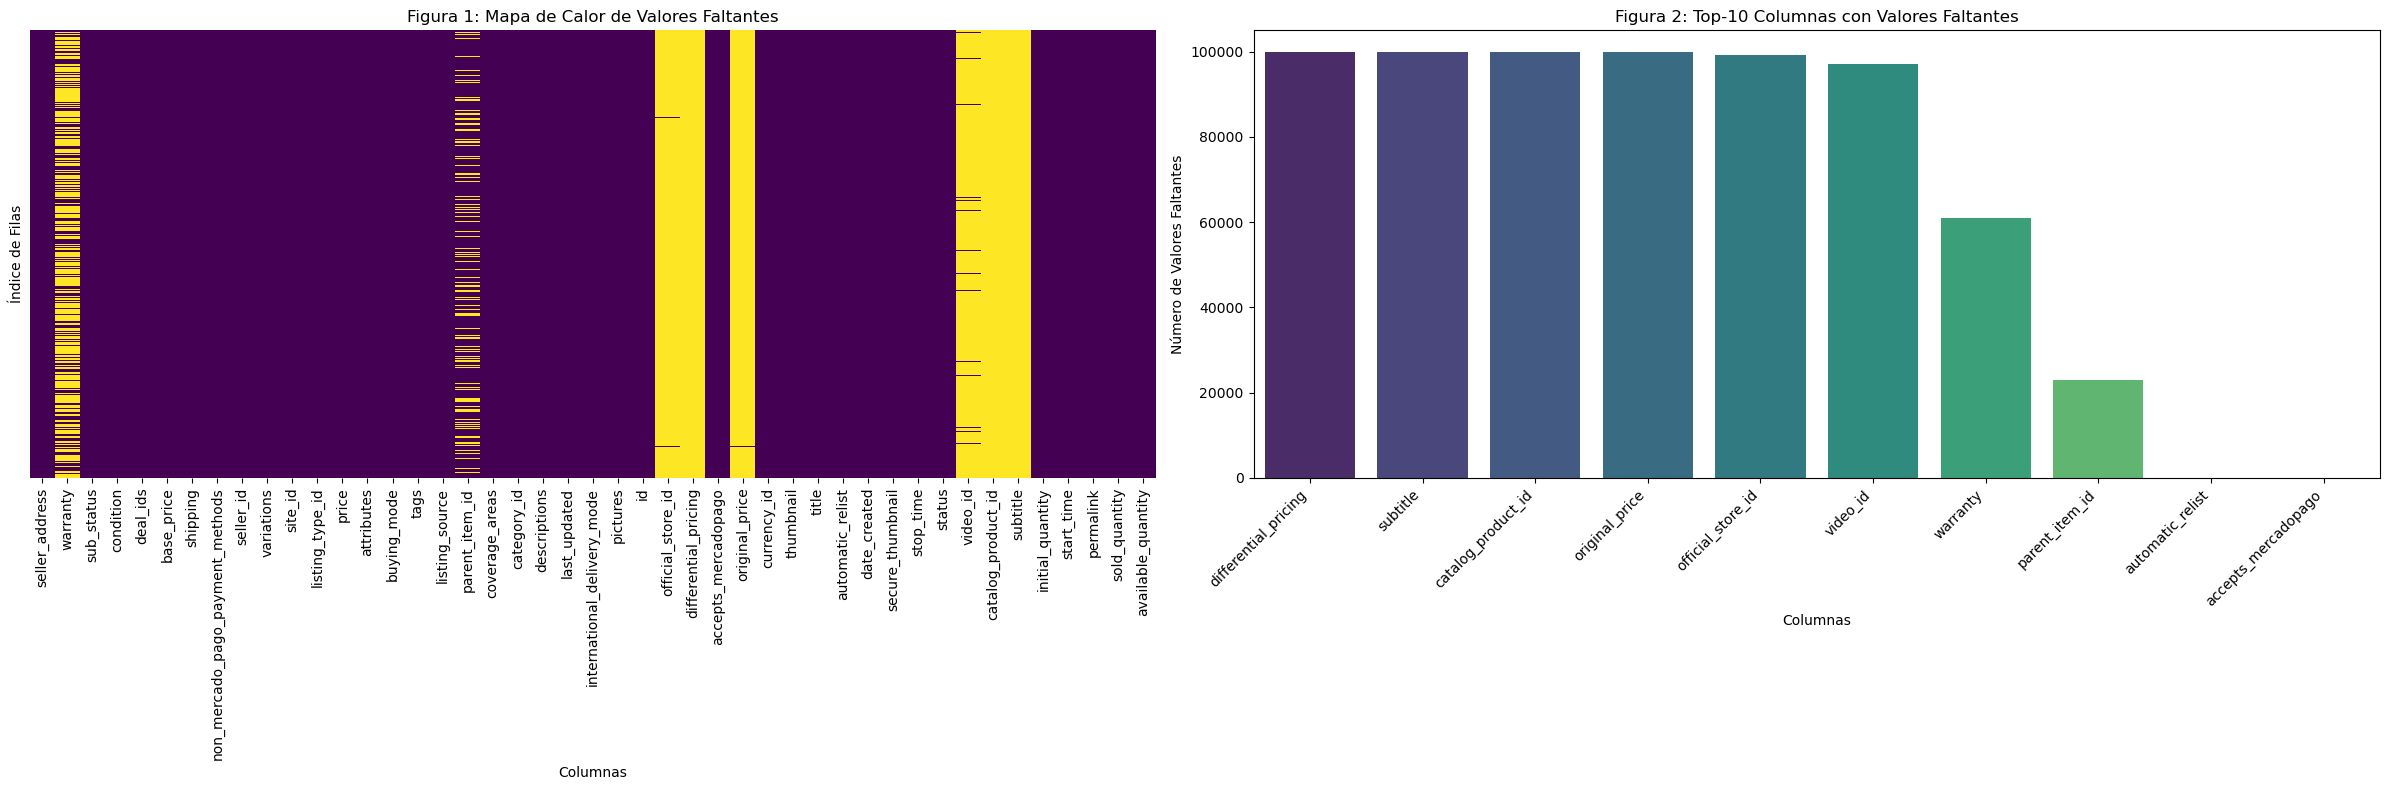

differential_pricing    100000
subtitle                100000
catalog_product_id       99989
original_price           99857
official_store_id        99182
video_id                 97015
warranty                 60896
parent_item_id           23011
automatic_relist             0
accepts_mercadopago          0
dtype: int64


In [6]:
# Cantidad total de NaN
total_nan = df.isnull().sum().sum()

# Cantidad de filas con al menos un NaN
filas_con_nan = df.isnull().any(axis=1).sum()

print(f"total de NaNs: {total_nan}")
print(f"total de filas con NaNs: {filas_con_nan}")

# Calculando la matriz de valores faltantes y las top-10 columnas con más valores faltantes
nan_matrix = df.isnull()
top_k_nan_columnas = df.isnull().sum().sort_values(ascending=False).head(10)

# Configurando el layout de la figura para los gráficos lado a lado
fig, ax = plt.subplots(1, 2, figsize=(24, 8))


# Mapa de Calor de Valores Faltantes
sns.heatmap(nan_matrix, cbar=False, yticklabels=False, cmap='viridis', ax=ax[0])
ax[0].set_title('Figura 1: Mapa de Calor de Valores Faltantes')
ax[0].set_xlabel('Columnas')
ax[0].set_ylabel('Índice de Filas')

# Gráfico de Barras para las Columnas con Valores Faltantes
# Ajustando para evitar advertencia y error
sns.barplot(x=top_k_nan_columnas.index, y=top_k_nan_columnas.values, palette='viridis', ax=ax[1])
ax[1].set_title('Figura 2: Top-10 Columnas con Valores Faltantes')
ax[1].set_xlabel('Columnas')
ax[1].set_ylabel('Número de Valores Faltantes')
ax[1].set_xticklabels(top_k_nan_columnas.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(top_k_nan_columnas)

In [7]:
# marcando y eliminando columnas revisadas
columns_to_delete = ['differential_pricing', 'subtitle', 'catalog_product_id', 'original_price', 'official_store_id', 'video_id']
df = df.drop(columns=columns_to_delete)

# Revision de tipos de datos de las columnas.

Avanzamos con la revision de tipos de datos en las diferentes columnas de dataset.
esto lo realizamos para hacer los procesos de revision y de limpieza de forma mas organizada.

In [8]:
# Primero obtenemos los diferentes tipos por columna 
type_per_column = {column: df[column].apply(type).unique().tolist() for column in df.columns}
# Filtrar columnas que tienen más de un tipo de dato
columns_with_multiple_types = {column: types for column, types in type_per_column.items() if len(types) > 1}

print(columns_with_multiple_types)


{'warranty': [<class 'NoneType'>, <class 'str'>], 'parent_item_id': [<class 'str'>, <class 'NoneType'>]}


In [9]:
# Ahora agrupamos los tipos y obtenemos para cada tipo las columnas que tienen de ese tipo.
data_types_to_columns = {}

for column, types in type_per_column.items():
    for type_ in types:
        type_ = str(type_).split("'")[1]
        if type_ not in data_types_to_columns:
            data_types_to_columns[type_] = [column]
        else:
            data_types_to_columns[type_].append(column)

data_items = [(key, ', '.join(value)) for key, value in data_types_to_columns.items()]
dtf = pd.DataFrame(data_items, columns=['Tipo de Dato', 'Columnas'])

styled_df = dtf.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [
            ('background-color', '#606060'),
            ('color', 'white'),
            ('font-family', 'Arial'),
            ('border-color', 'black')
        ]
    }, {
        'selector': 'td',
        'props': [
            ('text-align', 'left'),
            ('font-family', 'Arial'),
            ('border-color', 'black')
        ]
    }]
).set_properties(**{
    'background-color': '#f4f4f4',
    'color': 'black'
})

styled_df

,Tipo de Dato,Columnas
0,dict,"seller_address, shipping"
1,NoneType,"warranty, parent_item_id"
2,str,"warranty, condition, site_id, listing_type_id, buying_mode, listing_source, parent_item_id, category_id, last_updated, international_delivery_mode, id, currency_id, thumbnail, title, date_created, secure_thumbnail, status, permalink"
3,list,"sub_status, deal_ids, non_mercado_pago_payment_methods, variations, attributes, tags, coverage_areas, descriptions, pictures"
4,float,"base_price, price"
5,int,"seller_id, stop_time, initial_quantity, start_time, sold_quantity, available_quantity"
6,bool,"accepts_mercadopago, automatic_relist"


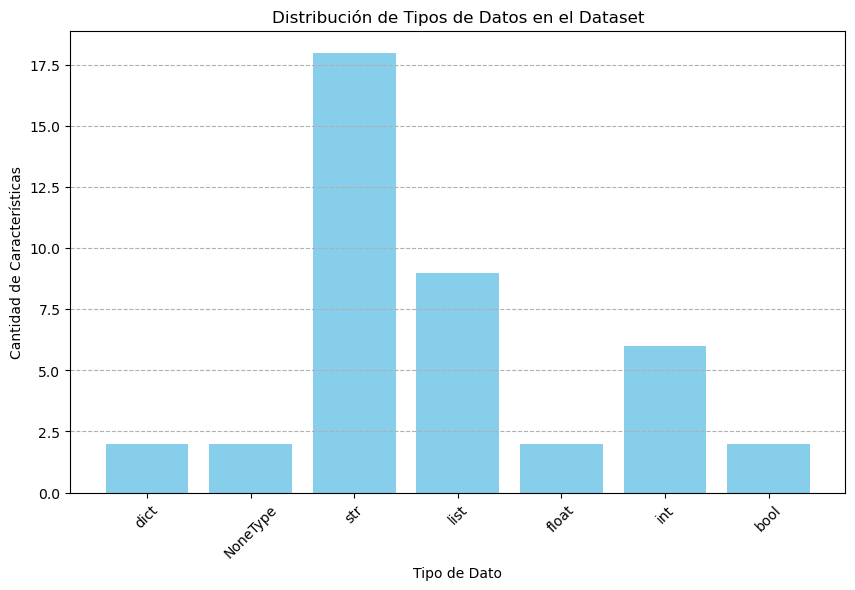

In [10]:
# Ahora veremos como distribuyen los tipos
types = list(data_types_to_columns.keys())
# Convertir los tipos a strings para que puedan ser usados como etiquetas
counts = [len(data_types_to_columns[key]) for key in types]

# Creación del gráfico
plt.figure(figsize=(10, 6))
plt.bar(types, counts, color='skyblue')
plt.title('Distribución de Tipos de Datos en el Dataset')
plt.xlabel('Tipo de Dato')
plt.ylabel('Cantidad de Características')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Mostrar el gráfico
plt.show()

## Revision de las columnas del tipo dict

En esta categoria tenemos dos columnas `seller_address`, `shipping`, ambas columnas son objetos.

* `seller_address`: Objeto encargado de la direccion del vendedor la cual no aporta informacion a la pregunta que queremos resolver. El formato del objeto es este:
```json
    {
        'country': {
            'name': 'Argentina',
            'id': 'AR'
        },
        'state': {
            'name': 'Capital Federal',
            'id': 'AR-C'
        },
        'city': {
            'name': 'San Cristóbal',
            'id': 'TUxBQlNBTjkwNTZa'
        }
    }

```

* `shipping`: es un objeto interesante, ya que podria ser que el free_shipping podria ayudarnos a saber si un objeto es usado o no, por lo tanto haremos un analisis de sus variables.

```json
    {
        'local_pick_up': True,
        'methods': [],
        'tags': [],
        'free_shipping': False,
        'mode': 'me2',
        'dimensions': None
    }

```


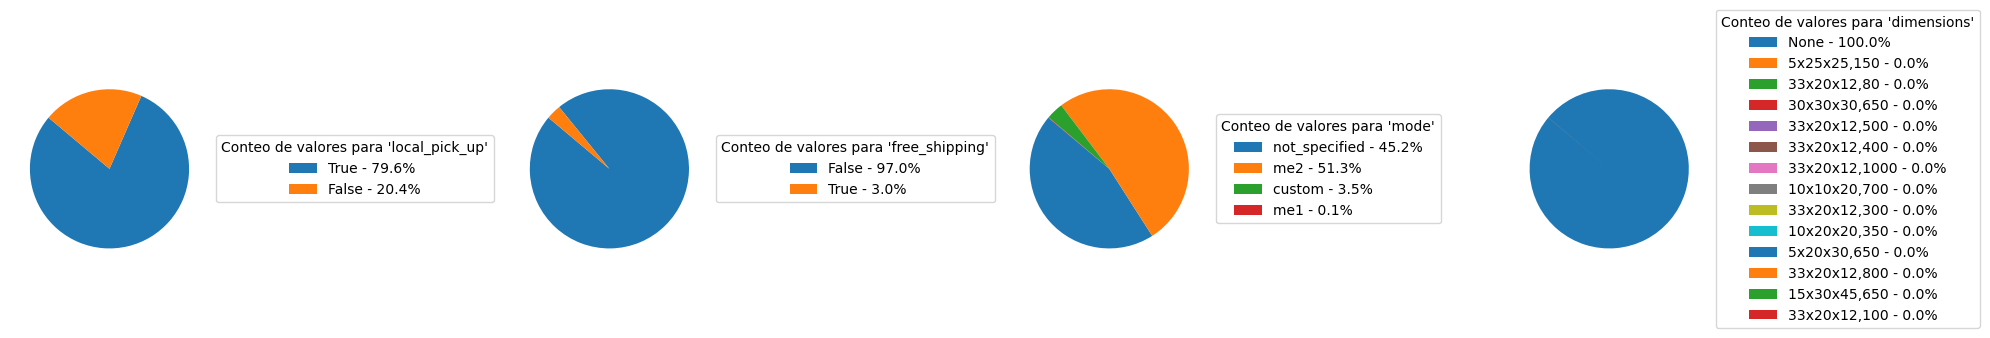

In [11]:
# Contamos valores de cada una de las columnas de interes.

# Inicializamos diccionarios para almacenar los valores únicos y sus conteos para cada columna de interés
conteos_local_pick_up = {}
conteos_free_shipping = {}
conteos_mode = {}
conteos_dimensions = {}

# Iteramos a través de cada objeto en la lista para extraer los valores y contarlos
for objeto in df['shipping']:
    local_pick_up = objeto['local_pick_up']
    free_shipping = objeto['free_shipping']
    mode = objeto['mode']
    dimensions = objeto['dimensions'] if objeto['dimensions'] is not None else 'None'  # Tratamos None como una cadena para contar
    
    # Incrementamos el conteo para cada valor encontrado
    conteos_local_pick_up[local_pick_up] = conteos_local_pick_up.get(local_pick_up, 0) + 1
    conteos_free_shipping[free_shipping] = conteos_free_shipping.get(free_shipping, 0) + 1
    conteos_mode[mode] = conteos_mode.get(mode, 0) + 1
    conteos_dimensions[dimensions] = conteos_dimensions.get(dimensions, 0) + 1

# Configuramos una sola fila de subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Ajusta el tamaño de la figura según necesites

# Títulos y datos como antes
titulos = [
    "Conteo de valores para 'local_pick_up'",
    "Conteo de valores para 'free_shipping'",
    "Conteo de valores para 'mode'",
    "Conteo de valores para 'dimensions'"
]

datos = [
    conteos_local_pick_up,
    conteos_free_shipping,
    conteos_mode,
    conteos_dimensions
]

# Recorremos cada subplot y lo llenamos con los datos correspondientes
for ax, titulo, dato in zip(axs, titulos, datos):
    # Los valores y las etiquetas para el gráfico de torta
    valores = list(dato.values())
    etiquetas = list(dato.keys())
    # Calculamos los porcentajes para las leyendas
    porcentajes = [f'{etiqueta} - {valor/sum(valores)*100:.1f}%' for etiqueta, valor in dato.items()]
    # Dibujamos el gráfico de torta
    wedges, texts = ax.pie(valores, startangle=140)
    # Añadimos la leyenda
    ax.legend(wedges, porcentajes, title=titulo, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_aspect('equal')  # Aseguramos que el gráfico de torta sea circular

# Ajustamos el layout para evitar superposiciones y asegurar que las leyendas sean visibles
plt.tight_layout()
plt.show()

Podemos observar que:
* `local_pick_up`: esta distribuida en un ~79% True y ~21% False.
* `free_shipping`: tiene un ~97% False y un ~3% True. lo cual no da mucha información.
* `mode`: esta mitad y mitad entre dos de las 4 clases.
* `dimensions`: casi el 100% de los casos son None.


### Revisando las variables que son de tipo `Dict` podemos concluir:
* El objeto `seller_address` sera descartado.
* Del objeto `shipping` utilizaremos las varialbes `local_pick_up` y `mode`, todas las demas variables seran descartadas.

In [12]:
# marcando y eliminando columnas revisadas
columns_to_delete = ['seller_address']
df.drop(columns=columns_to_delete, axis=1, inplace=True)

# Paso 1: Extraer 'local_pick_up' y 'mode' de cada diccionario en 'shipping'
df['shipping_local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up', None))
df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode', None))

# Paso 3: Eliminar la columna 'shipping' del DataFrame
df.drop('shipping', axis=1, inplace=True)


## Revision de las columnas del tipo `str`

Dado que muchos valores no aportan informacion descartaremos los siguientes:

- Por ser la variable que tratamos de predecir: [`condition`]
- Por ser IDs: [`site_id`, `parent_item_id`, `category_id`, `id`, `currency_id`]
- Por estar Vacios: [`listing_source`, `international_delivery_mode`]
- Por ser URLs o Links: [`thumbnail`, `secure_thumbnail`, `permalink`]

Nos quedamos con variables de tres tipos:

- Categoricas: [`buying_mode`, `status`, `listing_type_id`]
- Texto: [`warranty`, `title`]
- Fechas: [`last_updated`, `date_created`]


#### Analisis de variables Categoricas

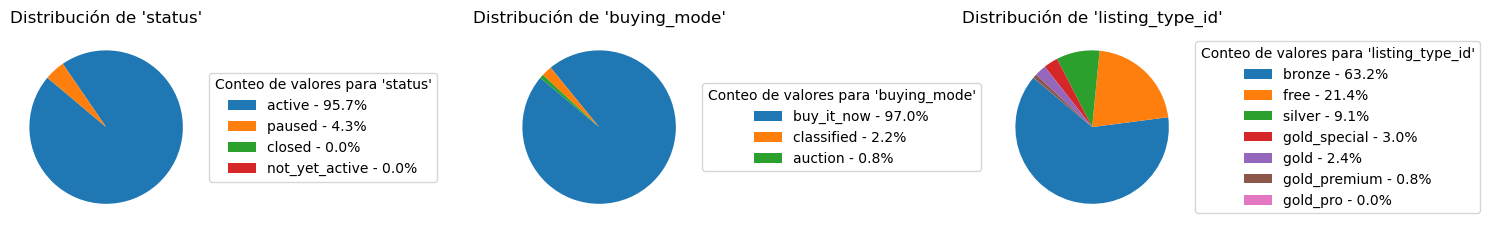

In [13]:
# Analizaremos las variables categoricas

# Lista de columnas de interés
columnas = ['status', 'buying_mode', 'listing_type_id']

# Configuramos una fila de subplots basada en el número de columnas
fig, axs = plt.subplots(1, len(columnas), figsize=(15, 8))  # Ajusta el tamaño según necesites

# Iteramos sobre las columnas y los axes para crear un gráfico de torta para cada uno
for col, ax in zip(columnas, axs.flatten()):
    # Contamos los valores de la columna actual
    conteos = df[col].value_counts()

    # Los valores y las etiquetas para el gráfico de torta
    valores = conteos.values
    etiquetas = conteos.index
    
    # Calculamos los porcentajes para las leyendas
    porcentajes = [f'{etiqueta} - {valor/sum(valores)*100:.1f}%' for etiqueta, valor in zip(etiquetas, valores)]
    
    # Dibujamos el gráfico de torta
    wedges, texts = ax.pie(valores, startangle=140)
    
    # Añadimos la leyenda
    ax.legend(wedges, porcentajes, title=f"Conteo de valores para '{col}'", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    ax.set_aspect('equal')  # Aseguramos que el gráfico de torta sea circular
    ax.set_title(f"Distribución de '{col}'")

# Ajustamos el layout para evitar superposiciones y asegurar que las leyendas sean visibles
plt.tight_layout()
plt.show()


#### Analisis de variables de texto

Primero se realiza una limpieza de los datos de texto, se utiliza la funcion clean_text para:

- Se transforman todos los caracteres a ASCII.
- Se combierten todas las letras en minusculas.
- Se eliminan los numeros.
- Se elimina la puntuacion.
- Se realiza el tokenizado.
- Se eliminan los token stop words.
- Se realiza la stemizacion para transformar las palabras en sus raices.

In [14]:
# Inicialización de Stemmer y Stopwords en español
stemmer = SnowballStemmer('spanish')
stop_words = set(stopwords.words('spanish'))

def clean_text(text):
    if text is None:
        return text
    
    # Normalizar el texto para eliminar acentos
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    tokens = word_tokenize(text)  # Tokenizar
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Aplicar stemming
    return tokens

# Aplicar la función de limpieza a una columna del DataFrame
df['title_clean'] = df['title'].apply(clean_text).apply(lambda x: ' '.join(x) if x else '')
df['warranty_clean'] = df['warranty'].apply(clean_text).apply(lambda x: ' '.join(x) if x else '')



In [15]:
df['title_clean'].value_counts()

title_clean
suspensor short ban tel cal                  112
suspensor short ban nid abej                  75
suspensor short ban tel nid abej              48
confeccion short ban bermud hombr nin         42
camis cort confeccion product termin          31
                                            ... 
botell gres cervez sinusoidal sigl             1
zapatill cuer marron franc pasotti             1
hacedor mund doming sant editorial ultram      1
botell porron gres antigu ginebr bols          1
libr religi practic piad sra fatim             1
Name: count, Length: 97662, dtype: int64

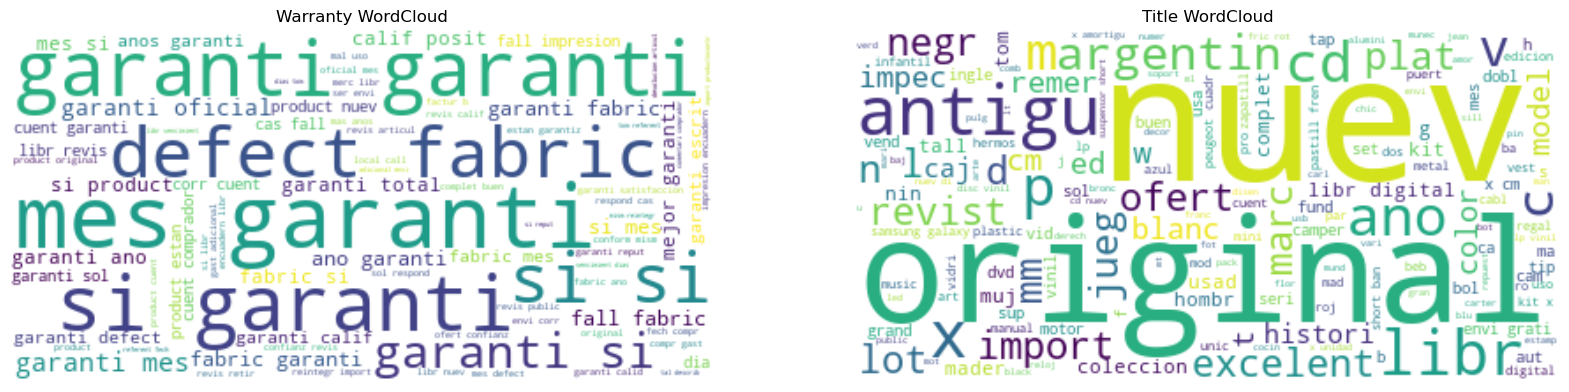

In [16]:
title_clean = df['title_clean'].apply(lambda x: x.split(' '))
warranty_clean = df['warranty_clean'].apply(lambda x: x.split(' '))

title_clean = ' '.join([word for token in title_clean for word in token])
warranty_clean = ' '.join([word for tokens in warranty_clean if tokens is not None for word in tokens if word is not None])

# Inicializar WordCloud
wordcloud1 = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue')
wordcloud2 = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue')

# Generar las nubes de palabras
wordcloud1.generate(warranty_clean)
wordcloud2.generate(title_clean)

# Configurar la visualización
plt.figure(figsize=(20, 7))  # Ajustar el tamaño para acomodar ambas nubes de palabras

# Nube de palabras para 'warranty_clean'
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Warranty WordCloud')  # Opcional: agregar un título

# Nube de palabras para 'title_clean'
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Title WordCloud')  # Opcional: agregar un título

plt.show()


Creamos un grafico Word Cloud para cada variable, podemos observar:
- En `title`, la predominancia de raices como `nuev`, `original`, `antigu`, etc. nos ayudaran a reconocer si es usado o nuevo.
- En waranty`, existe una predominancia por raices con sufijos: `garanti`

Mas adelante en la seccion de ingenieria de caracteristicas veremos como utilizar estos descubrimientos.

#### Analisis de variables de tipo Fechas

Las fechas estan codificadas en el formato ISO8601, mas adelante discutiremos como las incluiremos en las caracteristicas.

### Revisando las variables que son de tipo `str` podemos concluir:

Variables que seran descartadas:
- Por ser la variable que tratamos de predecir: [`condition`]
- Por ser IDs: [`site_id`, `parent_item_id`, `category_id`, `id`, `currency_id`]
- Por estar Vacios: [`listing_source`, `international_delivery_mode`]
- Por ser URLs o Links: [`thumbnail`, `secure_thumbnail`, `permalink`]

Variables que se utilizaran:

- Categoricas: [`buying_mode`, `status`]
- Texto: [`warranty`, `title`]
- Fechas: [`last_updated`, `date_created`]


In [17]:
columns_to_delete = ['site_id', 'parent_item_id', 'category_id', 'id', 'currency_id', 'listing_source', 'international_delivery_mode', 'thumbnail', 'secure_thumbnail', 'permalink']
df.drop(columns=columns_to_delete, axis=1, inplace=True)

## Revision de las columnas del tipo `List`

Se presentan diferentes variables, las analizaremos por diferentes grupos.

### Analisis de las variables `sub_status`, `deal_ids`, `variations`, `attributes`, `coverage_areas`

Todas estas variables en mas del ~95% de los casos son de valor nulo, por lo tanto no son variables que sirvan para el modelo

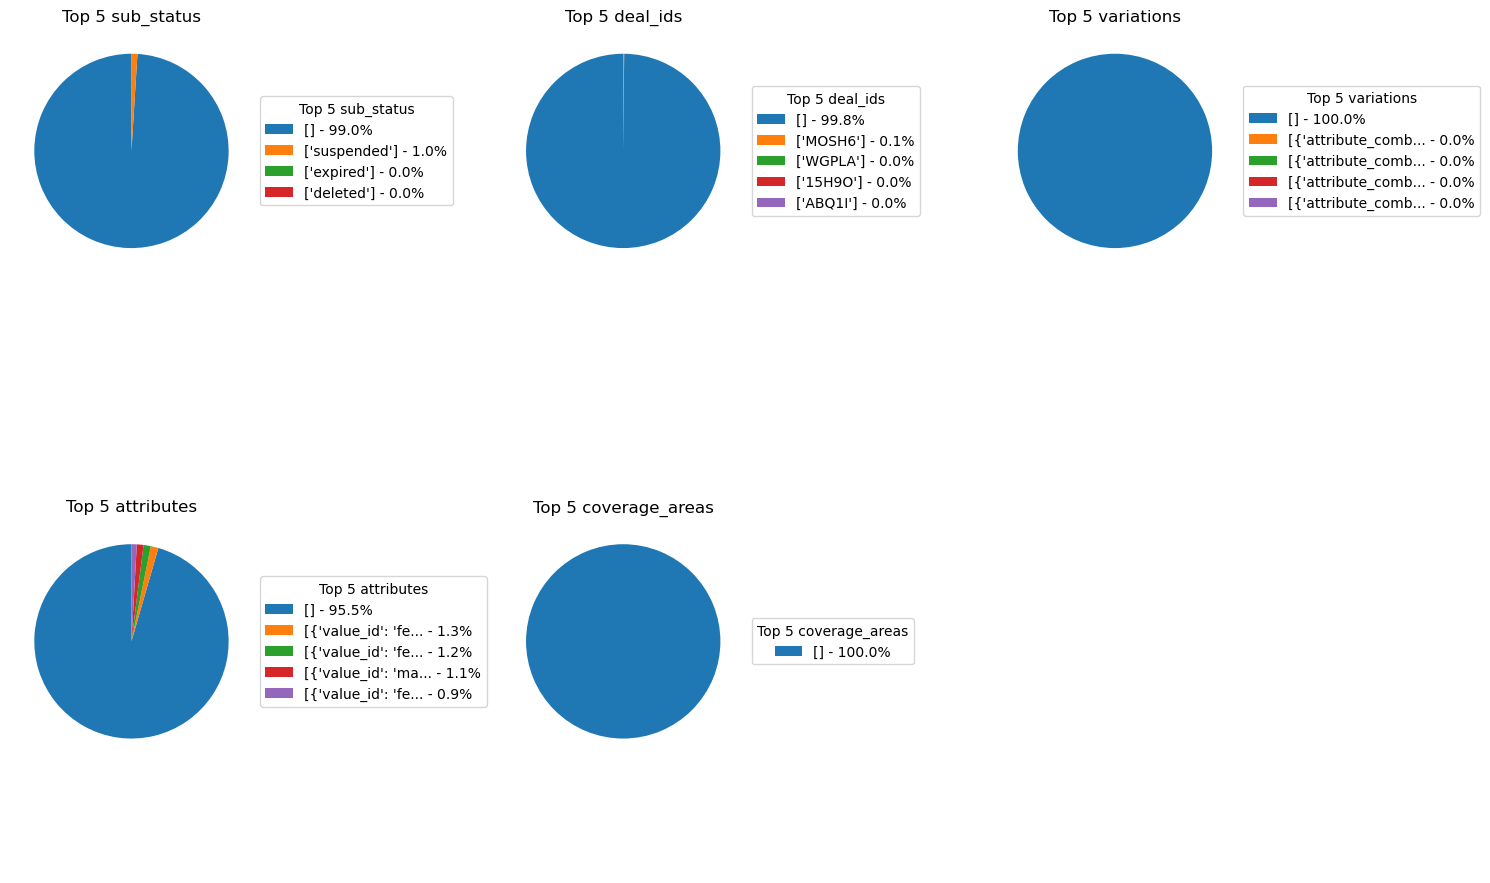

In [18]:

def plot_top_k_pie_charts(df, column_names, k=5):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Configurar la figura y los ejes
    axs = axs.flatten()  # Aplanar el array de ejes para facilitar el acceso
    
    # Recorrer los nombres de las columnas para graficar
    for i, column_name in enumerate(column_names):
        # Calcular los conteos de valores
        value_counts = df[column_name].value_counts().head(k)
        
        # Calcular porcentajes
        total = value_counts.sum()
        percentages = [(count/total)*100 for count in value_counts]

        new_indexes = []
        for label in value_counts.index:
            if isinstance(label, dict):
                label = json.dumps(label)
            elif not isinstance(label, str):
                label = str(label)
            new_indexes.append(label)
        value_counts.index = new_indexes
        
        # Preparar etiquetas para la leyenda con longitud ajustada y porcentajes
        labels_with_perc = [f'{label if len(label) <= 20 else label[:17] + "..."} - {perc:.1f}%' for label, perc in zip(value_counts.index, percentages)]
        
        # Dibujar el gráfico de torta
        axs[i].pie(value_counts, startangle=90)
        
        # Añadir leyenda al gráfico con etiquetas y porcentajes
        axs[i].legend(title=f"Top {k} {column_name}", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), labels=labels_with_perc)
        
        axs[i].set_title(f'Top {k} {column_name}')
    
    # Ocultar los ejes no utilizados
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()  # Ajustar el layout
    plt.show()

# Lista de nombres de columnas para las que deseas crear gráficos de torta
column_names = ['sub_status', 'deal_ids', 'variations', 'attributes', 'coverage_areas']

# Llama a la función con el DataFrame y los nombres de las columnas
plot_top_k_pie_charts(df, column_names, k=5)


### Analisis de las variable `tags`

Esta variable al parecer es de uso interno del aplicativo de MeLi.


In [19]:
df['tags'].value_counts()

tags
[dragged_bids_and_visits]                            72551
[]                                                   24910
[good_quality_thumbnail, dragged_bids_and_visits]     1330
[dragged_visits]                                       516
[good_quality_thumbnail]                               392
[dragged_visits, free_relist]                          285
[poor_quality_thumbnail, dragged_bids_and_visits]       11
[poor_quality_thumbnail]                                 5
Name: count, dtype: int64

### Analisis de las variable  `descriptions`
Son IDs del comentario, no existe acceso al comentario :'(, podria ayudar tambien.

```
descriptions
[]                                     2688
[{'id': 'MLA4695330653-912855983'}]       1
[{'id': 'MLA5935841584-908398166'}]       1
[{'id': 'MLA8441753636-926508210'}]       1
[{'id': 'MLA7990148772-898793381'}]       1
                                       ... 
[{'id': 'MLA2857846687-936247635'}]       1
[{'id': 'MLA7675068934-904476069'}]       1
[{'id': 'MLA7460941130-940449329'}]       1
[{'id': 'MLA6220495235-927725554'}]       1
[{'id': 'MLA9372431786-925955158'}]       1
Name: count, Length: 97313, dtype: int64
```

In [20]:
# df['descriptions'].value_counts()

### Analisis de las variable  `pictures`

Son objetos con links y la metadata de las fotos, como no tenemos acceso lo descartaremos.

In [21]:
# Esta comentado porque demora mucho
# df['pictures'].value_counts()

### Analisis de las variable  `non_mercado_pago_payment_methods`
De todos los datos que aparecen en los diferentes objetos de tipo de pago, nos quedaremos con la descripcion y la utilizaremos como una variable categorica ya que esxisten solo  14 diferentes.

In [22]:
df['non_mercado_pago_payment_methods_categorical'] = df['non_mercado_pago_payment_methods'].apply(
    lambda x: [item['description'] for item in x] if isinstance(x, list) else x
)


### Revisando las variables que son de tipo `List` podemos concluir:

Variables que seran descartadas:
- Variables con mas del 95% de las respuestas vacias [`sub_status`, `deal_ids`, `variations`, `attributes`, `coverage_areas`]
- Variables de Uso interno de MeLi (Creemos): [`tags`]
- Variables que solo tienen un id o lista de ids: [`descriptions`]
- Variables que tienen las fotos de los productos: [`pictures`]

  
Variables que se utilizaran:

- Categoricas: [`non_mercado_pago_payment_methods`]


In [23]:
columns_to_delete = ['sub_status', 'deal_ids', 'variations', 'attributes', 'coverage_areas', 'tags', 'descriptions', 'pictures']
df.drop(columns=columns_to_delete, axis=1, inplace=True)

## Revision de las columnas del tipo `Float`

### Analisis de las variables `base_price`y `price`

Son variables numericas, no se describe cual es la diferencia de ambos, revisaremos cuantas son diferentes entre todos los productos.


In [24]:
# Comparamos las columnas 'price' y 'base_price' para cada fila
iguales = df['price'] == df['base_price']

# Contamos cuántas filas tienen valores iguales
filas_iguales = iguales.sum()

# Contamos cuántas filas tienen valores diferentes
filas_diferentes = len(df) - filas_iguales

print(f"Filas con valores iguales: {filas_iguales}")
print(f"Filas con valores diferentes: {filas_diferentes}")

Filas con valores iguales: 99971
Filas con valores diferentes: 29


### Revisando las variables que son de tipo `Float` podemos concluir:

Variables que seran descartadas:

- `base_price` sera descartada ya que en mas del 99% de los casos es igual a price (solo en 29 de 100k casos es diferente).

Variables que se utilizaran:

- `price`

In [25]:
columns_to_delete = ['base_price']
df.drop(columns=columns_to_delete, axis=1, inplace=True)

## Revision de las columnas del tipo `int`


### Analisis de las variables `seller_id`

Al ser un id este sera descartado

### Analisis de las variables `start_time` y `stop_time`

Son variables del tipo `timestamp` mas adelante revisaremos como incluirla al modelo

### Analisis de las variables `initial_quantity`, `sold_quantity`, `available_quantity`

Son variables que marcan las cantidades tanto iniciales, vendidas y qwue todavia tienen:

- `initial_quantity`: cerca del 70% solo tiene 1 producto.
- `sold_quantity`: cerca del 80% no ha vendido nada.
- `available_quantity`: cerca 70% aun tiene 1 producto.

### Revisando las variables que son de tipo `Int` podemos concluir:

Variables que seran descartadas:

- Por ser IDs: [`seller_id`]

Variables que se utilizaran:

- Fechas en formato `timestamp`: [`stop_time`, `start_time`]
- Numericas que indican la cantidad del producto: [`initial_quantity`, `sold_quantity`, `available_quantity`]


In [26]:
columns_to_delete = ['seller_id']
df.drop(columns=columns_to_delete, axis=1, inplace=True)

## Revision de las columnas del tipo `bool`


### Analisis de las variables `accepts_mercadopago` y `automatic_relist`

Son variables booleanas donde el 97% y el 95% de los datos estan en un valor respectivamente.


### Revisando las variables que son de tipo `Bool` podemos concluir:

Variables que seran descartadas:

- `accepts_mercadopago` el 97% de los casos son `False`.
- `automatic_relist` el 95% de los casos son `False`.

In [27]:
columns_to_delete = ['accepts_mercadopago', 'automatic_relist']
df.drop(columns=columns_to_delete, axis=1, inplace=True)

## Revision de relaciones y correlaciones de variables


Tenemos las variables separadas por tipo:

Categoricas:
- shipping_mode
- listing_type_id
- buying_mode
- status
- non_mercado_pago_payment_methods -> non_mercado_pago_payment_methods_categorical

Texto: 
- warranty -> warranty_clean
- title -> title_clean

Fechas:
- last_updated (ISO)
- date_created (ISO)
- stop_time (int)
- start_time (int)

Bool:
- shipping_local_pick_up

Numerico:
- price (flot)
- initial_quantity
- sold_quantity
- available_quantity


### Analisis de las relaciones entre `condition` y las variables categoricas.

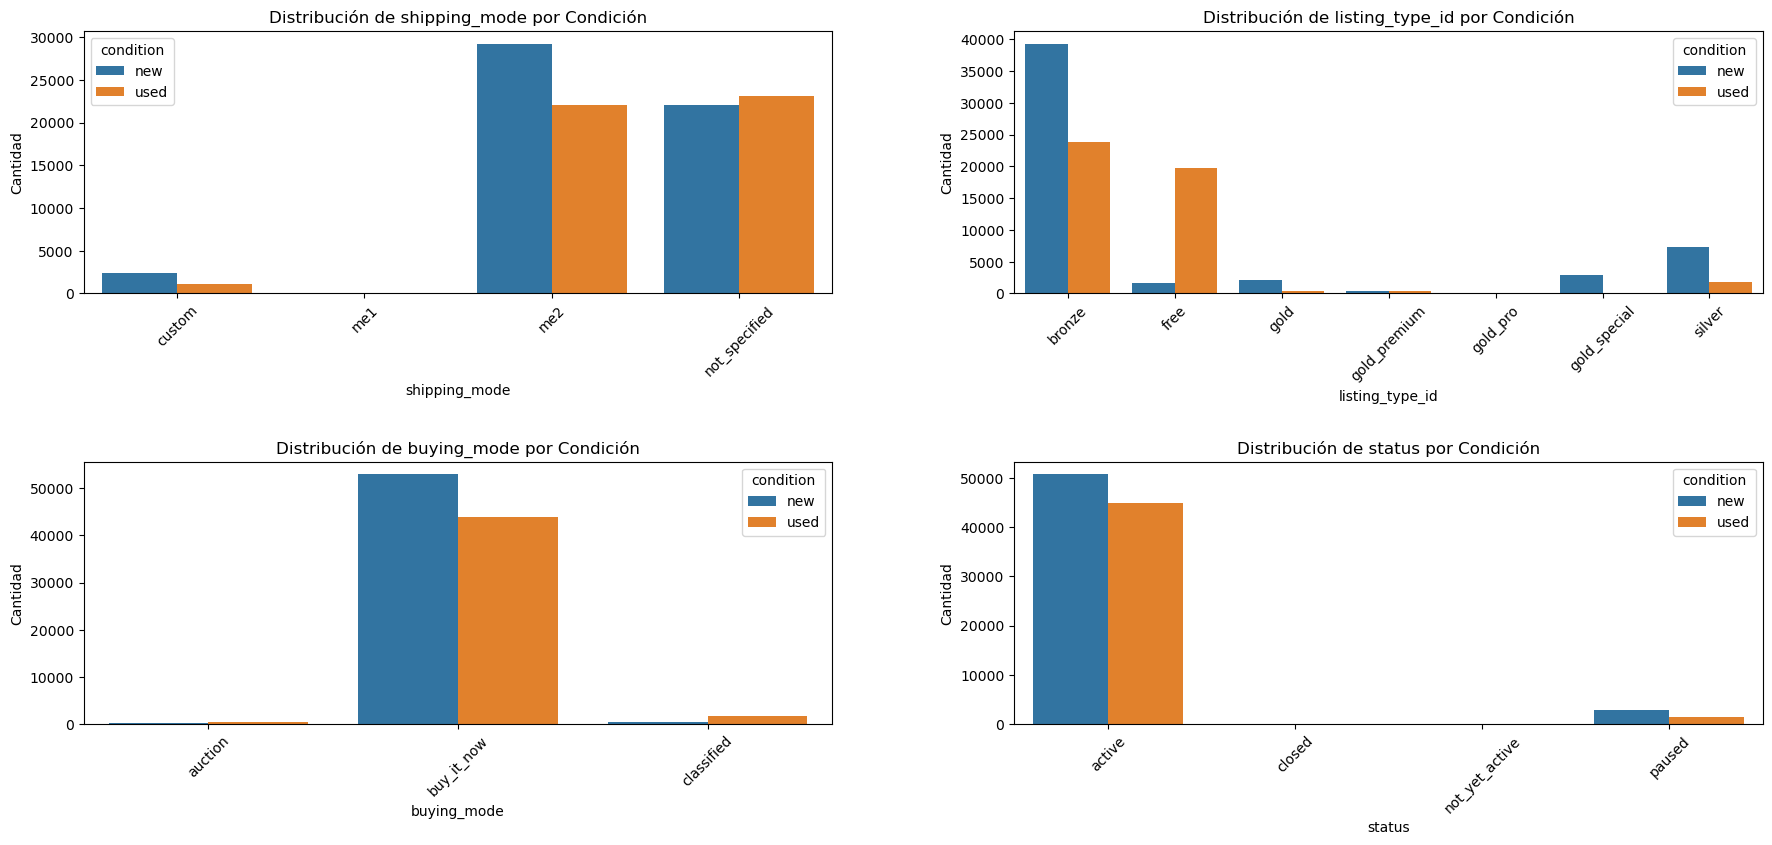

In [28]:
# Lista de características categóricas
categorical_features = ['shipping_mode', 'listing_type_id', 'buying_mode', 'status']

# Número de filas necesarias para subplot basado en la cantidad de características
n_rows = (len(categorical_features) + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(20, n_rows*5))
fig.tight_layout(pad=10.0)

for i, feature in enumerate(categorical_features):
    # Selecciona el subplot actual
    ax = axes[i//2, i%2]
    
    # Crea un dataframe que conteo por categoría y condición
    category_counts = df.groupby([feature, 'condition']).size().reset_index(name='counts')
    
    # Crea el gráfico de barras
    sns.barplot(x=feature, y='counts', hue='condition', data=category_counts, ax=ax)
    
    ax.set_title(f'Distribución de {feature} por Condición')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Cantidad')
    ax.tick_params(axis='x', rotation=45)

if len(categorical_features) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.show()

En general el equilibrio entre `new` y `used` en casi todas las categorias no muestra predominancia de ciertas etiquetas, salvo en el caso de la etiqueta `free` de la variable listing_type_id, la cual nos muestra que en general cuando se utiliza ese tipo de `listing` el articulo es `used`, esta sera una etiqueta muy poderosa para nuestro modelo.

### Analisis de las variables numericas:

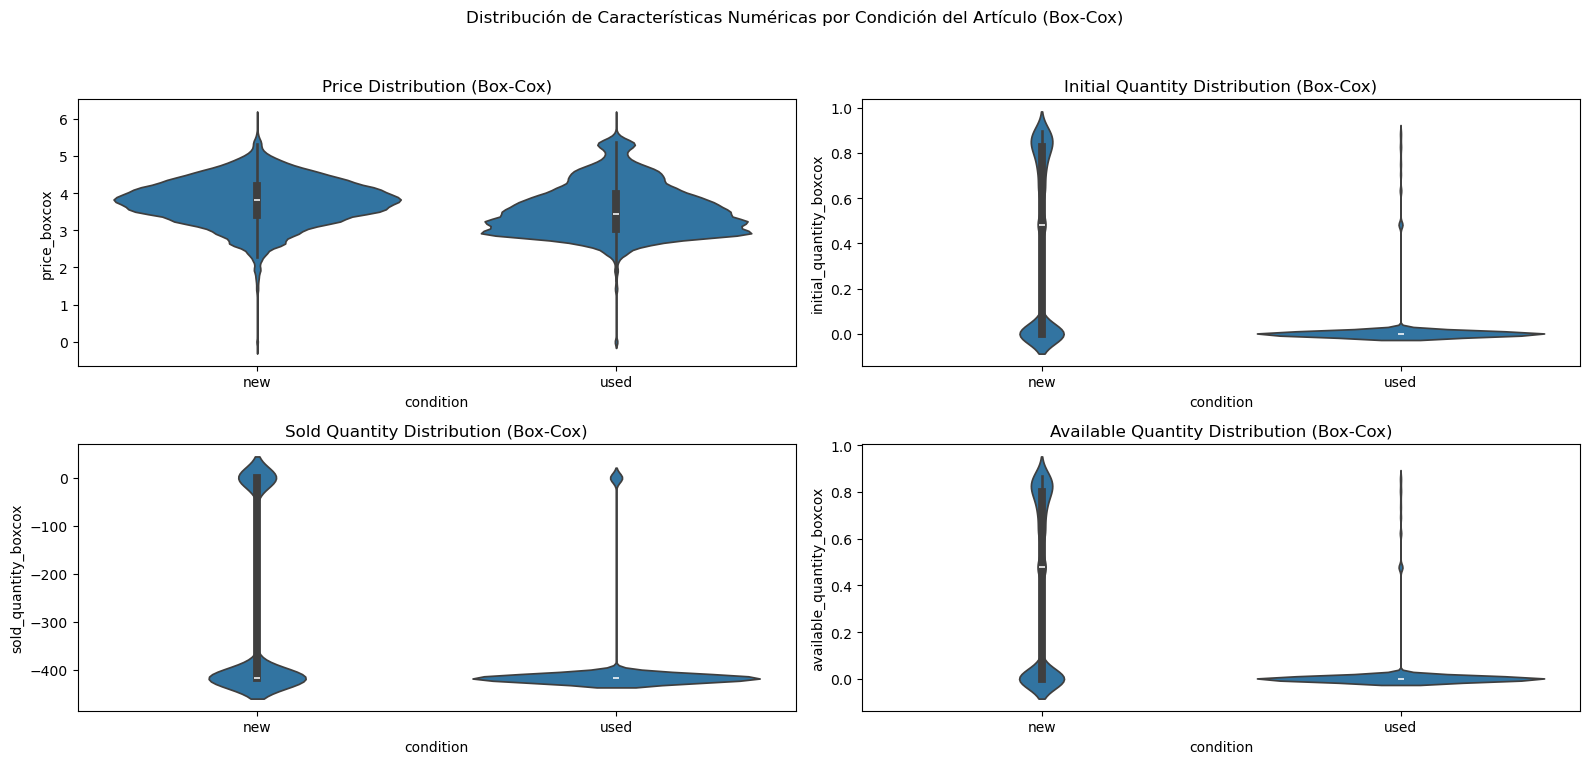

In [29]:

# Creando un nuevo DataFrame para almacenar los valores transformados por Box-Cox
df_transformed = pd.DataFrame()

# Aplicando la transformación Box-Cox a cada variable numérica y almacenándolas en el nuevo DataFrame
# Se añade una pequeña constante para asegurar que no haya valores cero
df_transformed['price_boxcox'], _ = stats.boxcox(df['price'] + 1e-5)
df_transformed['initial_quantity_boxcox'], _ = stats.boxcox(df['initial_quantity'] + 1e-5)
df_transformed['sold_quantity_boxcox'], _ = stats.boxcox(df['sold_quantity'] + 1e-5)
df_transformed['available_quantity_boxcox'], _ = stats.boxcox(df['available_quantity'] + 1e-5)

# Añadimos la variable 'condition' al nuevo DataFrame para los gráficos
df_transformed['condition'] = df['condition']

# Configurando los gráficos con las variables transformadas con Box-Cox
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Distribución de Características Numéricas por Condición del Artículo (Box-Cox)')

# Violin plot para 'price' transformado con Box-Cox
sns.violinplot(ax=axes[0, 0], x='condition', y='price_boxcox', data=df_transformed)
axes[0, 0].set_title('Price Distribution (Box-Cox)')

# Violin plot para 'initial_quantity' transformado con Box-Cox
sns.violinplot(ax=axes[0, 1], x='condition', y='initial_quantity_boxcox', data=df_transformed)
axes[0, 1].set_title('Initial Quantity Distribution (Box-Cox)')

# Violin plot para 'sold_quantity' transformado con Box-Cox
sns.violinplot(ax=axes[1, 0], x='condition', y='sold_quantity_boxcox', data=df_transformed)
axes[1, 0].set_title('Sold Quantity Distribution (Box-Cox)')

# Violin plot para 'available_quantity' transformado con Box-Cox
sns.violinplot(ax=axes[1, 1], x='condition', y='available_quantity_boxcox', data=df_transformed)
axes[1, 1].set_title('Available Quantity Distribution (Box-Cox)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- Revisando la variable price podemos observar que existen un equilibrio entre los precios y si son usados o nuevos
- Por otro lado las variables `initial_quantity`, `sold_quantity`, `available_quantity`, se ve que existe una predominancia de valores mayores cuando el articulo esta nuevo.

Se utilizo una transformacion Box-Cox para poder visualizar mejor los violin plots, al momento de construir el vector de caracteristicas estos valores deben ser normalizados.

### Analisis de variables booleanas

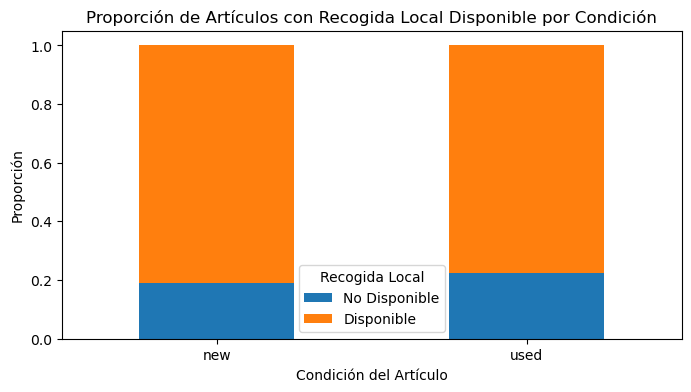

In [30]:
# Calculando las proporciones
pickup_proportions = df.groupby('condition')['shipping_local_pick_up'].value_counts(normalize=True).unstack().fillna(0)

# Creando el gráfico de barras
pickup_proportions.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Proporción de Artículos con Recogida Local Disponible por Condición')
plt.xlabel('Condición del Artículo')
plt.ylabel('Proporción')
plt.xticks(rotation=0)
plt.legend(title='Recogida Local', labels=['No Disponible', 'Disponible'])
plt.show()

Podemos observar que no hay diferencias significativas si un artivulo es usado o nuevo con esta variable.

## Proceso de preparacion de los datos.

### Transformacion de las variables categoricas a one hot encoding

In [31]:
def one_hot_encode_column(df_origen, column_name):
    """
    Realiza la codificación One-Hot de una columna categórica y retorna un nuevo DataFrame
    con el resultado de la codificación.

    Parámetros:
    - df_origen: DataFrame de pandas que contiene la columna a codificar.
    - column_name: Nombre de la columna en el df_origen que será codificada.
    
    Retorna:
    - Un nuevo DataFrame con las columnas resultantes de la codificación One-Hot.
    """
    # Realizar la codificación One-Hot y retornar el resultado
    dummies = pd.get_dummies(df_origen[column_name], prefix=column_name)
    return dummies


df_final = pd.DataFrame(index=df.index)

columns_to_encode = ['shipping_mode', 'listing_type_id', 'buying_mode', 'status', ]

# Aplicar la función a cada columna categórica
for column in columns_to_encode:
    df_final = pd.concat([df_final, one_hot_encode_column(df, column)], axis=1)


In [32]:
def encode_multilabel_column(df_origen, column_name, prefix):
    """
    Codifica una columna que contiene listas de categorías (multilabel) en un DataFrame
    y retorna un nuevo DataFrame con el resultado de la codificación. Todas las columnas
    resultantes tendrán un prefijo especificado.

    Parámetros:
    - df_origen: DataFrame de pandas que contiene la columna a codificar.
    - column_name: Nombre de la columna en el df_origen que será codificada.
    - prefix: Prefijo que se añadirá a los nombres de las nuevas columnas codificadas.
    
    Retorna:
    - Un nuevo DataFrame con las columnas resultantes de la codificación multilabel,
      con un prefijo añadido a cada nombre de columna.
    """
    # Inicializar el codificador MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Aplicar la codificación a la columna especificada
    encoded_data = mlb.fit_transform(df_origen[column_name])

    # Añadir el prefijo a los nombres de las columnas generadas
    new_column_names = [f"{prefix}_{c}" for c in mlb.classes_]

    # Crear un DataFrame con el resultado codificado y los nombres de columnas actualizados
    encoded_df = pd.DataFrame(encoded_data, columns=new_column_names, index=df_origen.index)

    return encoded_df

df_final = pd.concat([df_final, encode_multilabel_column(df, 'non_mercado_pago_payment_methods_categorical', 'payment_methods')], axis=1)

### Transformacion de variables tipo Fecha

De las variables `last_updated`, `date_created` sera extraido el mes y año, para ver si existen patrones de estaciones del año.

In [33]:
def extract_year_month(df, date_column):
    # Verificar que la columna de fecha exista en el DataFrame
    if date_column not in df.columns:
        raise ValueError(f"La columna '{date_column}' no existe en el DataFrame.")
    
    # Convertir la columna especificada a datetime sin modificar el DataFrame original
    date_series = pd.to_datetime(df[date_column])
    
    # Extraer año y mes en un nuevo DataFrame
    new_df = pd.DataFrame({
        f'{date_column}_year': date_series.dt.year,
        f'{date_column}_month': date_series.dt.month
    })
    
    return new_df
    
columns_to_encode = ['last_updated', 'date_created']

# Aplicar la función a cada columna categórica
for column in columns_to_encode:
    df_final = pd.concat([df_final, extract_year_month(df, column)], axis=1)


De las variables `start_time`, `stop_time` calcularemos la diferencia.

In [34]:
def calcular_diferencia_duracion(df, columna_fecha_inicial, columna_fecha_final):
    # Verificar que las columnas existan en el DataFrame
    if columna_fecha_inicial not in df.columns or columna_fecha_final not in df.columns:
        raise ValueError("Una o ambas columnas especificadas no existen en el DataFrame.")
    
    # Convertir las columnas de timestamp a datetime si aún no lo están
    fecha_inicial = pd.to_datetime(df[columna_fecha_inicial], unit='ms')
    fecha_final = pd.to_datetime(df[columna_fecha_final], unit='ms')
    
    # Calcular la diferencia en días
    diferencia_dias = (fecha_final - fecha_inicial).dt.days
    
    # Crear un nuevo DataFrame con la columna de diferencia nombrada específicamente
    nombre_columna_diferencia = f'diff_{columna_fecha_inicial}_{columna_fecha_final}'
    resultado_df = pd.DataFrame(diferencia_dias, columns=[nombre_columna_diferencia])
    
    return resultado_df

df_final = pd.concat([df_final, calcular_diferencia_duracion(df, 'start_time', 'stop_time')], axis=1)


### Transformacion de varialbes tipo Bool
Estas variables seran incluidas directamente debido a que no neceistan ninguna transformacion.

### Transformacion de variables de tipo Numerica
Utilizaremos estandarizacion, pero esto sera realziado con los parametros de entrenamiento y aplicaremos estos a los de test, asi evitamos el cruce de datos.


In [35]:
columns_num = ['price', 'initial_quantity', 'sold_quantity', 'available_quantity']

for col in columns_num:
    df_final = pd.concat([df_final, df[col]], axis=1)



### Transformacion de variables de tipo Texto
Utilizaremos tf-idf para esto es necesario solo hacerlo con los datos de entrenamiento y aplicar el patron a los test para no tener problemas de cruce de datos que no podemos ver

In [36]:
columns_text = ['warranty_clean', 'title_clean']

for col in columns_text:
    df_final = pd.concat([df_final, df[col]], axis=1)


### Agregar columna condition

Por ultimo agregamos la columna condition a la muestra.

In [37]:
from sklearn.preprocessing import LabelEncoder

# Crear una instancia de LabelEncoder
encoder = LabelEncoder()

# Ajustar el encoder y transformar la columna 'condition', luego convertir el resultado a un DataFrame
condition_encoded = pd.DataFrame(encoder.fit_transform(df['condition']), columns=['condition'])

# Concatenar el DataFrame resultante con df_final a lo largo del eje de las columnas
df_final = pd.concat([df_final, condition_encoded], axis=1)

# Verificar el resultado
df_final.head()

,shipping_mode_custom,shipping_mode_me1,shipping_mode_me2,shipping_mode_not_specified,listing_type_id_bronze,listing_type_id_free,listing_type_id_gold,listing_type_id_gold_premium,listing_type_id_gold_pro,listing_type_id_gold_special,...,date_created_year,date_created_month,diff_start_time_stop_time,price,initial_quantity,sold_quantity,available_quantity,warranty_clean,title_clean,condition
0,False,False,False,True,True,False,False,False,False,False,...,2015,9,60,80.0,1,0,1,,auricular samsung original man libr cabl usb o...,0
1,False,False,True,False,False,False,False,False,False,False,...,2015,9,60,2650.0,1,0,1,reput,cuchill dag acer carbon casc yelm soling vain,1
2,False,False,True,False,True,False,False,False,False,False,...,2015,9,60,60.0,1,0,1,,antigu revist billik n ano,1
3,False,False,True,False,False,False,False,False,False,False,...,2015,9,66,580.0,1,0,1,,alarm guardtex gx segur automotor,0
4,False,False,False,True,True,False,False,False,False,False,...,2015,8,60,30.0,1,0,1,reput,serenat jennif blak,1


In [38]:
## Columnas que seran utilizadas.
print(df_final.columns)
print(len(df_final.columns))

Index(['shipping_mode_custom', 'shipping_mode_me1', 'shipping_mode_me2',
       'shipping_mode_not_specified', 'listing_type_id_bronze',
       'listing_type_id_free', 'listing_type_id_gold',
       'listing_type_id_gold_premium', 'listing_type_id_gold_pro',
       'listing_type_id_gold_special', 'listing_type_id_silver',
       'buying_mode_auction', 'buying_mode_buy_it_now',
       'buying_mode_classified', 'status_active', 'status_closed',
       'status_not_yet_active', 'status_paused',
       'payment_methods_Acordar con el comprador',
       'payment_methods_American Express',
       'payment_methods_Cheque certificado',
       'payment_methods_Contra reembolso', 'payment_methods_Diners',
       'payment_methods_Efectivo', 'payment_methods_Giro postal',
       'payment_methods_MasterCard', 'payment_methods_Mastercard Maestro',
       'payment_methods_MercadoPago', 'payment_methods_Tarjeta de crédito',
       'payment_methods_Transferencia bancaria', 'payment_methods_Visa',
      

# Proceso de Seleccion de modelo

este proceso lo divideremos en diferentes pasos:
- Division de la base de datos (utilizando el script otorgado)
- Creacion de los k-fold para validar metricas
- Creacion de vectores de las varaibles textuales
- Estandarizacion de las variables numericas
- Creacion de base line (regresion logistica)
- Prueba con al menos 5 modelos mas
    - SVM
    - Random forrest
    - boosting
    - DNN
- Eleccion del modelo. 

## Division de la base de datos (utilizando el script otorgado)

In [39]:
columnas_deseadas = ['warranty_clean', 'title_clean', 'condition', 'payment_methods_Acordar con el comprador', 'payment_methods_American Express', 'payment_methods_Cheque certificado', 'payment_methods_Contra reembolso', 'payment_methods_Diners', 'payment_methods_Efectivo', 'payment_methods_Giro postal', 'payment_methods_MasterCard', 'payment_methods_Mastercard Maestro', 'payment_methods_MercadoPago', 'payment_methods_Tarjeta de crédito', 'payment_methods_Transferencia bancaria', 'payment_methods_Visa', 'payment_methods_Visa Electron', 'last_updated_year', 'last_updated_month', 'date_created_year', 'date_created_month', 'diff_start_time_stop_time', 'price', 'shipping_mode_custom', 'shipping_mode_me1', 'shipping_mode_me2', 'shipping_mode_not_specified', 'listing_type_id_bronze', 'listing_type_id_free', 'listing_type_id_gold', 'listing_type_id_gold_premium', 'listing_type_id_gold_pro', 'listing_type_id_gold_special', 'listing_type_id_silver', 'buying_mode_auction', 'buying_mode_buy_it_now', 'buying_mode_classified', 'status_active', 'status_closed', 'status_not_yet_active', 'status_paused']

df_copia = df_final[columnas_deseadas].copy()

def build_dataset_pandas(df):
    N = -10000
    
    if N < 0:
        N = len(df) + N
    
    # Divide el DataFrame en conjuntos de entrenamiento y prueba
    X_train = df.iloc[:N].drop('condition', axis=1)
    X_test = df.iloc[N:].drop('condition', axis=1)
    
    # Extrae las etiquetas de entrenamiento y prueba
    y_train = df.iloc[:N]['condition']
    y_test = df.iloc[N:]['condition']
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = build_dataset_pandas(df_copia)

## Creacion del pipeline de trabajo para los entrenamientos

Se realizaran difernetes tipos de transformaciones dependiendo del tipo de variables:
- Variables numericas seran estandarizadas.
- Variables booleanas seran transformadas en variables numericas con valor 0 o 1.
- Las variables booleanas que ya estan en valor 0 o 1 y las variables tipo date representadas numericamente no son transformadas. (Este metodo se utiliza ya que utilizando el `remainder='passthrough'` no funcionaba el codigo &#x1F622; )
- Por ultimo las variables textuales seran transformadas a vectores utilizando el metodo TF-IDF.

In [40]:
def bool_to_int(x):
    return x.astype(int)
# Definir una función de identidad para usar con FunctionTransformer
def identity_function(X):
    return X
# Crear un FunctionTransformer con la función de identidad
passthrough_transformer = FunctionTransformer(identity_function)


numeric_features = ['diff_start_time_stop_time', 'price']
bool_features = ['shipping_mode_custom', 'shipping_mode_me1', 'shipping_mode_me2', 'shipping_mode_not_specified', 'listing_type_id_bronze', 'listing_type_id_free', 'listing_type_id_gold', 'listing_type_id_gold_premium', 'listing_type_id_gold_pro', 'listing_type_id_gold_special', 'listing_type_id_silver', 'buying_mode_auction', 'buying_mode_buy_it_now', 'buying_mode_classified', 'status_active', 'status_closed', 'status_not_yet_active', 'status_paused']
bool_as_int = ['payment_methods_Acordar con el comprador', 'payment_methods_American Express', 'payment_methods_Cheque certificado', 'payment_methods_Contra reembolso', 'payment_methods_Diners', 'payment_methods_Efectivo', 'payment_methods_Giro postal', 'payment_methods_MasterCard', 'payment_methods_Mastercard Maestro', 'payment_methods_MercadoPago', 'payment_methods_Tarjeta de crédito', 'payment_methods_Transferencia bancaria', 'payment_methods_Visa', 'payment_methods_Visa Electron']
date_as_int = ['last_updated_year','last_updated_month','date_created_year','date_created_month']


# Creación del objeto preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bool', FunctionTransformer(bool_to_int), bool_features),
        ('bool_as_int', passthrough_transformer, bool_as_int),
        ('date_as_int', passthrough_transformer, date_as_int),
        ('title_tfidf', TfidfVectorizer(max_features=40000), 'title_clean'),
        ('warranty_tfidf', TfidfVectorizer(max_features=3000), 'warranty_clean')
    ]
)

## Creacion de k-folds
Se crea un Stratified K Fold para mantener distribucion de las clases de la base de datos en cada una de las particiones o fold.
Fijar el valor de la semilla sirve para que cada vez que se corra un kfold, los sub grupos siempre sean los mismos.

In [41]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Instanciación de Modelos
Para abordar nuestro problema, evaluaremos el rendimiento de una variedad de modelos de aprendizaje automático y redes neuronales profundas. Cada modelo será entrenado y validado utilizando el mismo conjunto de datos para asegurar una comparación justa. Los modelos seleccionados para esta comparación son:

- **Logistic Regression**: Un modelo de clasificación lineal simple pero efectivo para problemas binarios.
- **Random Forest Classifier**: Un ensamble de árboles de decisión que promedia las predicciones de múltiples árboles de decisión para mejorar la precisión y controlar el sobreajuste.
- **Gradient Boosting Classifier**: Un modelo de ensamble que construye secuencialmente árboles de decisión, cada uno tratando de corregir los errores del árbol anterior.
- **K-Nearest Neighbors (KNN)**: Un modelo no paramétrico que clasifica cada muestra basándose en las etiquetas de las K muestras más cercanas.
- **LightGBM Classifier (LGBMClassifier)**: Una implementación eficiente del algoritmo de gradient boosting que es popular por su velocidad y eficiencia, especialmente en grandes conjuntos de datos.
- **XGBoost Classifier (XGBClassifier)**: Otra implementación eficiente del algoritmo de gradient boosting conocida por su rendimiento en competencias de ciencia de datos.
- **Deep Neural Network (DNN)**: Una red neuronal profunda configurada para clasificación binaria, representando un enfoque de aprendizaje profundo para el problema.

In [45]:
def create_model1(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(64, input_dim=43038, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def create_model2(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(64, input_dim=43038, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
    
# Definición de modelos
models = {
    # Comentados ya que los procesos de busqueda ya fueron realizados, pero si desea
    # hacer un nuevo proceso de busqueda de un modelo especifico o agregarlo es solo
    # crear una nueva instancia o descomentar el modelo seleccionado, tambien agregar
    # en la siguiente seccion los parametros para la busqueda del modelo
    # 'LogisticRegression': LogisticRegression(max_iter=1000),
    # 'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'KNeighborsClassifier': KNeighborsClassifier(),
    # 'DNN_1': KerasClassifier(model=create_model1, verbose=1),
    # 'DNN_2': KerasClassifier(model=create_model2, verbose=1)
}

## Configuración de Parámetros para la Búsqueda Grid
Para optimizar los modelos seleccionados, realizaremos una búsqueda grid para encontrar la mejor combinación de parámetros.
La búsqueda grid nos permite explorar sistemáticamente múltiples combinaciones de parámetros y determinar cuál produce el mejor rendimiento del modelo.



In [46]:
# Definición de los parámetros para la búsqueda grid
param_grid = {
    'LogisticRegression': {
        'model__C': [0.1, 1, 10]
    },
    'RandomForestClassifier': {
        'model__n_estimators': [50, 100, 200]
    },
    'GradientBoostingClassifier': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'KNeighborsClassifier': {
        'model__n_neighbors': [3, 5, 7]
    },
    'DNN_1': {
        'model__epochs': [5, 15, 30, 50],
        'model__batch_size': [500, 1000]
    },
    'DNN_2': {
        'model__epochs': [5, 15, 30, 50],
        'model__batch_size': [500, 1000]
    }
}

## Búsqueda de Hiperparámetros y Selección de los Mejores Modelos

Para afinar los modelos seleccionados y determinar la configuración óptima de hiperparámetros, implementamos un proceso sistemático utilizando GridSearchCV. Este enfoque realiza una búsqueda exhaustiva sobre las combinaciones especificadas de parámetros para cada modelo, utilizando validación cruzada para evaluar su rendimiento. 

Para cada modelo se escogen los mejores parametros, se entrena un modelo con esos parametros y todo el `X_train`, este modelo el salvado para la posterior comparacion final.

In [47]:
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',  
    'f1_score': 'f1',
    'precision': 'precision',
    'roc_auc': 'roc_auc'
}

# Para almacenar los resultados de todos los modelos
best_models = {}

for name, model in models.items():
    current_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    grid_search = GridSearchCV(current_pipeline, param_grid[name], cv=kf, scoring=scoring, refit='accuracy', verbose=1, n_jobs=1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Capturar resultados
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model_name'] = name

    # Imprimir los mejores parámetros y la puntuación media de validación cruzada para cada métrica
    print(f"\nMejor modelo para {name}: {grid_search.best_params_}")
    
    params_str = "-".join([f"{k}:{v}" for k, v in grid_search.best_params_.items()])
    # Verificar si el modelo es de Keras
    if 'DNN' in name:
        # Acceder al modelo entrenado de Keras a través de model.model_
        best_model = grid_search.best_estimator_.named_steps['model'].model_
        filename = f"../models/{name}-{params_str}.tf"
        best_model.save(filename)  # Guardar el modelo de Keras
    else:
        # Modelo de scikit-learn, guardarlo usando joblib
        filename = f"../models/{name}-{params_str}.joblib"
        dump(grid_search.best_estimator_, filename)
    
    print(f"Modelo guardado como: {filename}")

## Creacion de un modelo ensemble con los tres mejores modelos.

Se crea un ultimo modelo de ensemble bassado en `VotingClassifier`, utilizando el metodo `soft`. Los modelos escogidos son:
- RandomForestClassifier
- DNN-1
- DNN-2

El modelo se entrena y queda listo para participar de las comparativas.

In [48]:
models_dir = '../models/ensemble'
ensemble_estimators = []

for filename in os.listdir(models_dir):
    file_path = os.path.join(models_dir, filename)
    model_name = filename.split('-')[0]
    
    if filename.endswith('.joblib'):
        # Cargar modelo scikit-learn
        model = load(file_path)
        # Crear un pipeline para scikit-learn models (integrando preprocessor si es necesario)
        ensemble_estimators.append((model_name, model))
        
    elif filename.endswith('.tf'):
        # Cargar modelo Keras
        def keras_model_loader():
            return load_model(file_path)

        pipeline = Pipeline([
            ('preprocessor', preprocessor),  # Asumiendo que preprocessor ya está definido
            ('model', KerasClassifier(model=keras_model_loader, epochs=1, batch_size=10, verbose=0))
        ])
        # Para modelos Keras, asumimos que el preprocesamiento necesario ya está incorporado o se manejará de forma externa
        ensemble_estimators.append((model_name, pipeline))
# Crear el Voting Classifier
ensemble = VotingClassifier(estimators=ensemble_estimators, voting='soft')

# Asegúrate de que X_test y y_test estén definidos y correctamente preprocesados si es necesario
ensemble.fit(X_train, y_train)  # Solo si necesitas entrenar el ensemble

2024-02-13 19:27:12.898787: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26020848 exceeds 10% of free system memory.
2024-02-13 19:33:41.251534: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26020848 exceeds 10% of free system memory.


VotingClassifier(estimators=[('DNN_1',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['diff_start_time_stop_time',
                                                                                 'price']),
                                                                               ('bool',
                                                                                FunctionTransformer(func=<function bool_to_int at 0xfffed54691c0>),
                                                                                ['shipping_mode_custom',
                                                                                 'shipping_mode_me1',
                                                                                 'shipping_mode_me2',
                                                                                 'shipping_mode_not_specified',
                                                                                 'listing_type_id_br...
                                                                                FunctionTransformer(func=<function identity_function at 0xfffed5469260>),
                                                                                ['last_updated_year',
                                                                                 'last_updated_month',
                                                                                 'date_created_year',
                                                                                 'date_created_month']),
                                                                               ('title_tfidf',
                                                                                TfidfVectorizer(max_features=40000),
                                                                                'title_clean'),
                                                                               ('warranty_tfidf',
                                                                                TfidfVectorizer(max_features=3000),
                                                                                'warranty_clean')])),
                                              ('model',
                                               KerasClassifier(batch_size=10, model=<function keras_model_loader at 0xfffed931eb60>, verbose=0))]))],
                 voting='soft')

## Calculo de las metricas sobre el conjunto de test

Cada uno de los mejores modelos guaraddos son cargados para una prediccion del conjunto `X_test`.

Para cada modelo se calculan las siguientes metricas:

- Accuracy
- F1-Score
- Precision
- Recall
- ROC-AUC

Tambien es calculada una matriz de confusion para un posterior analisis.

In [49]:
models_dir = '../models'

model_metrics = {}  # Diccionario para guardar las métricas
model_cm = {} # Diccionario para guardar las matrices de confusión

for filename in os.listdir(models_dir):
    if filename.endswith('.joblib') or filename.endswith('.tf'):
        file_path = os.path.join(models_dir, filename)
        if filename.endswith('.joblib'):
            model_name = filename.replace('.joblib', '')
            model = load(file_path)
            x_test = X_test
        elif filename.endswith('.tf'):
            model_name = filename.replace('.tf', '')
            model = load_model(file_path)
            preprocessor.fit(X_train)
            x_test = preprocessor.transform(X_test)

        y_pred = model.predict(x_test)
        if filename.endswith('.tf'):
            y_pred = np.round(y_pred).flatten()
        else:
            y_pred = np.round(y_pred)

        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_pred)
        }
        
        model_metrics[model_name] = metrics
        model_cm[model_name] = confusion_matrix(y_test, y_pred)

# Calculando para el ensemble
x_test = X_test        
y_pred = ensemble.predict(x_test)
y_pred = np.round(y_pred)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred)
}

model_metrics["ensemble"] = metrics
model_cm["ensemble"] = confusion_matrix(y_test, y_pred)

313/313 [==============================] - 0s 653us/step


## Analisis de las metricas.

Creamos diferentes graficos de barra para cada una de las metricas y los modelos.
Podemos analizar:
- De los modelos iniciales el que mejores resultados tiene para todas las metricas es el `RandomForestClassifier`.
- Los otros modelos que se acercan son los modelos `DNN`.
- El modelo ensemble tiene valores muy cercanos al `RandomForestClassifier`.

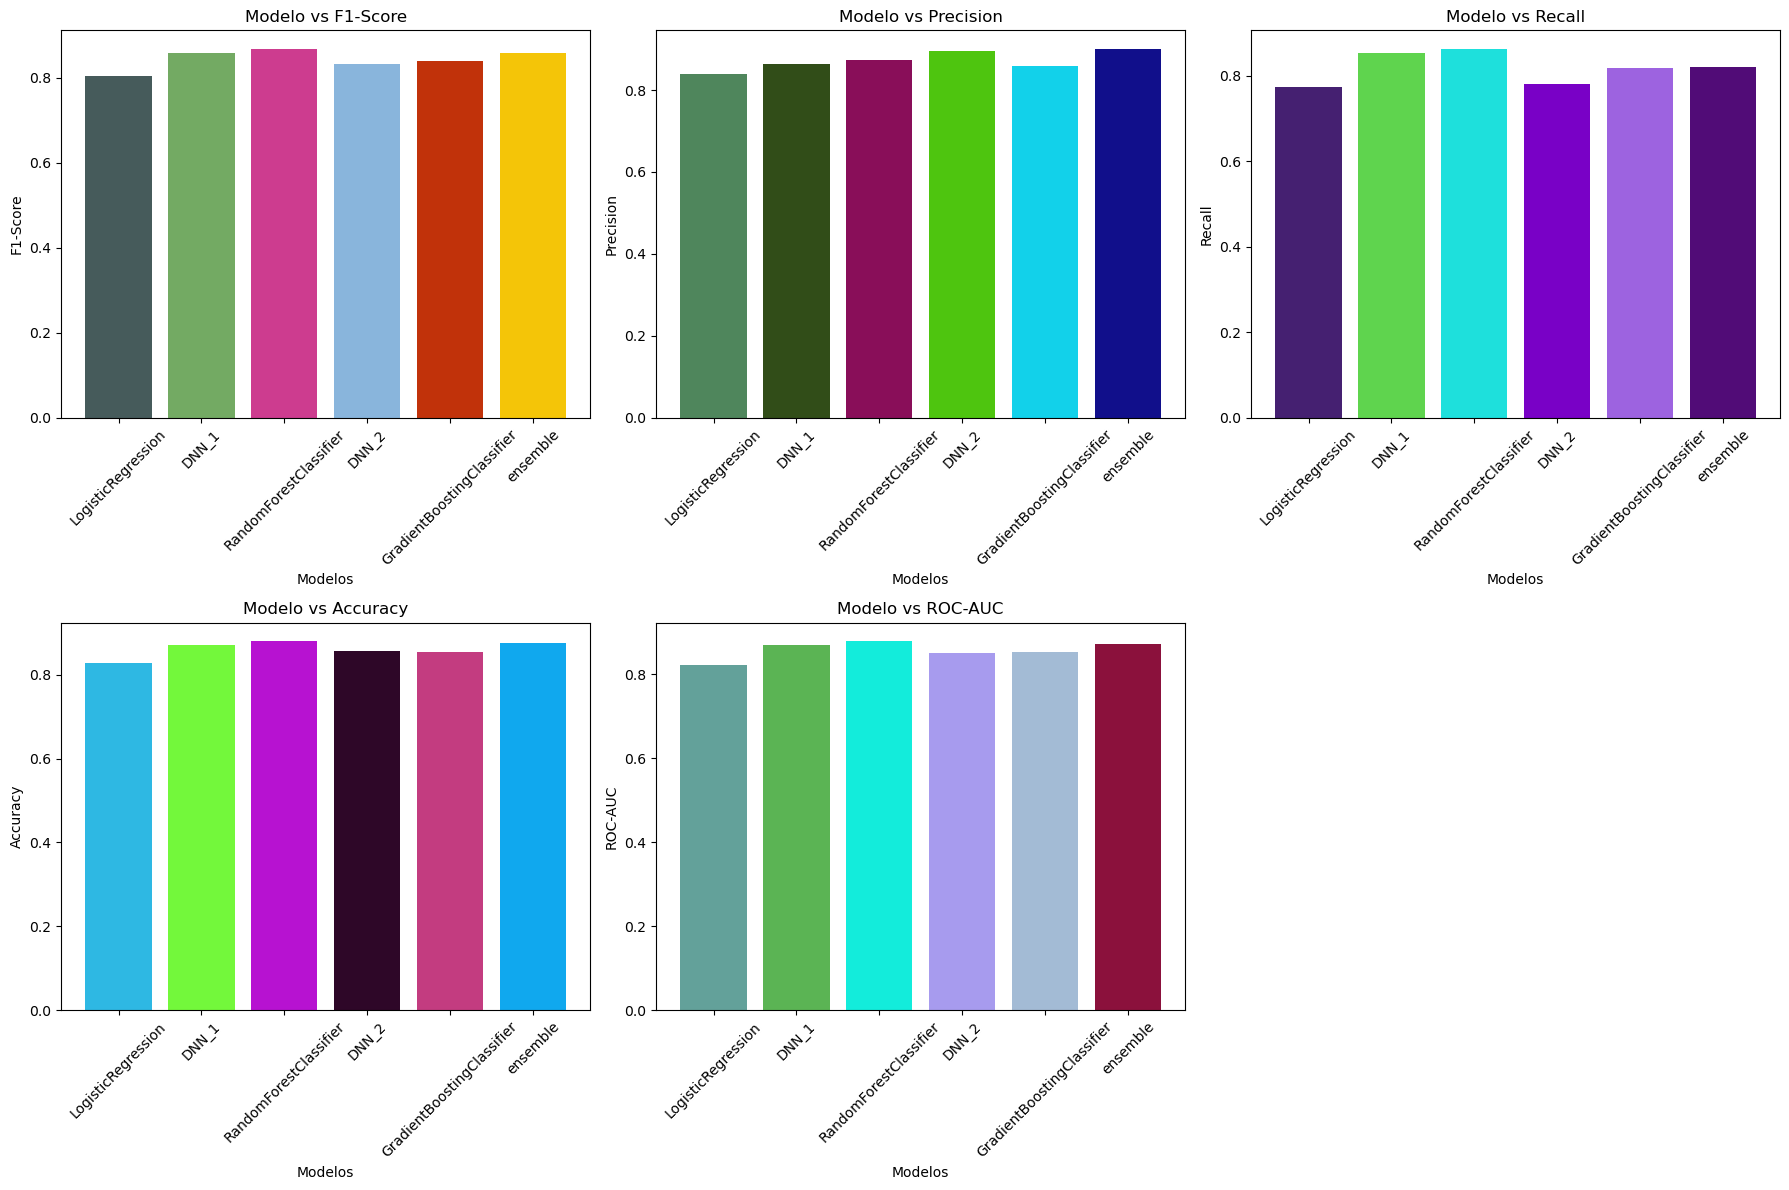

In [50]:
# Gráficos de Modelo vs Métrica
metrics = ['F1-Score', 'Precision', 'Recall', 'Accuracy', 'ROC-AUC']
plt.figure(figsize=(18, 12))  # Ajusta el tamaño de la figura

for i, metric in enumerate(metrics, start=1):
    plt.subplot(2, 3, i)  # Ajusta a 2x3 para que todos quepan en dos filas
    model_names = [model_name.split("-")[0] for model_name in model_metrics.keys()]
    metric_values = [model_metrics[model_name][metric] for model_name in model_metrics.keys()]
    plt.bar(model_names, metric_values, color=np.random.rand(len(model_metrics), 3))
    plt.xlabel('Modelos')
    plt.ylabel(metric)
    plt.title(f'Modelo vs {metric}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Ajusta el layout
plt.show()  # Muestra la primera figura


## Comparación de pares de metricas.

Comparamos las combinaciones de los valores de las metricas para cada modelo graficando 3 combinaciones:
- Accuracy vs F1-Score.
- Accuracy VS ROC-AUC.
- F1-Score VS ROC-AUC.

Mirando los graficos y las posiciones que hay en las comparativas de metricas, el modelo `RandomForstClassifier` es el mejor modelo que tenemos para clasificación

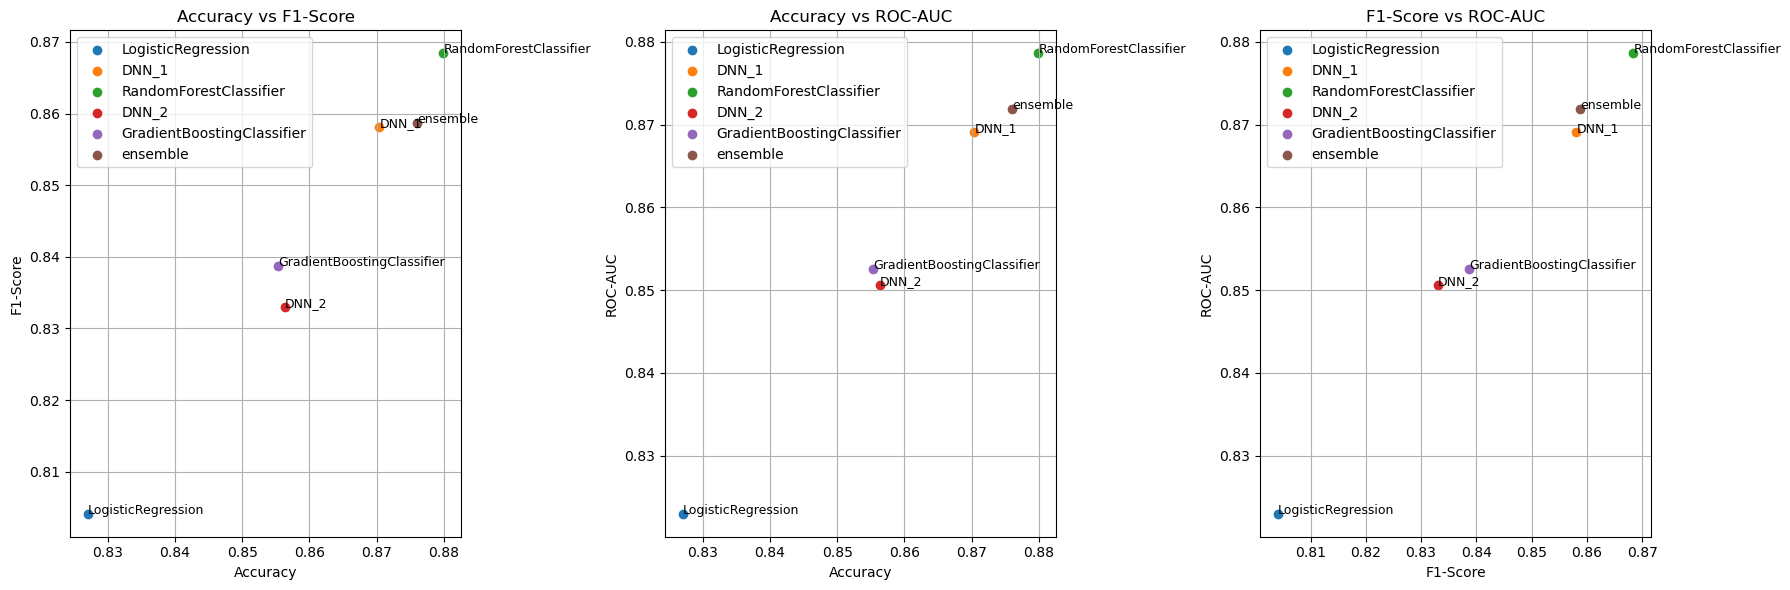

In [51]:
# Gráficos de Comparación de Métricas
comparison_metrics = [('Accuracy', 'F1-Score'), ('Accuracy', 'ROC-AUC'), ('F1-Score', 'ROC-AUC')]
plt.figure(figsize=(18, 6))  # Ajusta el tamaño para la figura de 1x3

for i, (metric1, metric2) in enumerate(comparison_metrics, start=1):
    plt.subplot(1, 3, i)  # Configura los subplots en una fila
    for model_name in model_metrics.keys():
        x = model_metrics[model_name][metric1]
        y = model_metrics[model_name][metric2]
        plt.scatter(x, y, label=model_name.split("-")[0])
        plt.text(x, y, model_name.split("-")[0], fontsize=9)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'{metric1} vs {metric2}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()  # Ajusta el layout
plt.show()  # Muestra la segunda figura


## Analisis de las matrices de confusión.

Para cada modelo se presentan las matrices de confusión.
Donde podemos volver a ver que el mejor modelo es el `RandomForstClassifier`.

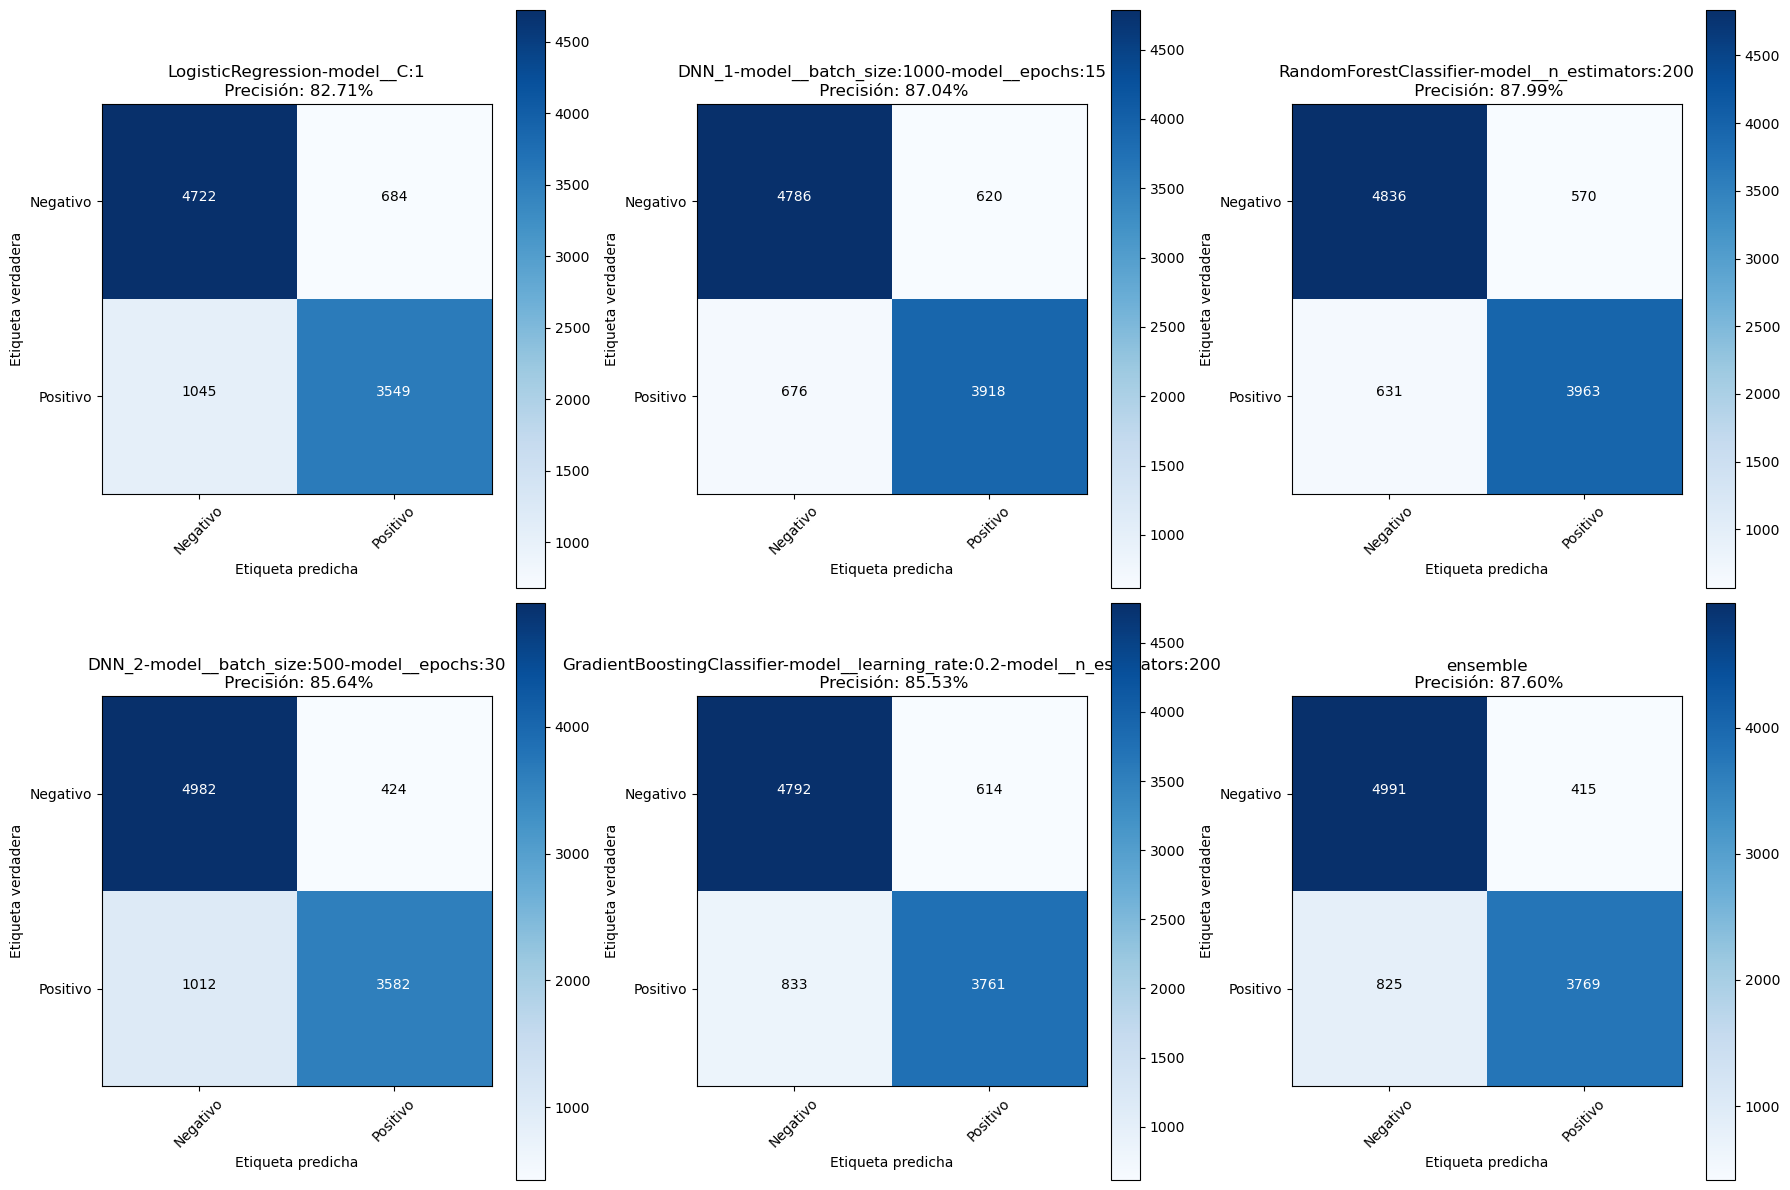

In [53]:
num_models = len(model_cm)
rows = num_models // 3 + (num_models % 3 > 0)  # Calcular el número de filas necesario
cols = 3  # Hasta 3 matrices por fila

plt.figure(figsize=(18, 6 * rows))  # Ajustar el tamaño de la figura basada en el número de filas

for i, (model_name, cm) in enumerate(model_cm.items(), start=1):
    accuracy = model_metrics[model_name]['Accuracy'] * 100  # Obtener la precisión para este modelo
    plt.subplot(rows, cols, i)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name}\n Precisión: {accuracy:.2f}%')  # Añadir la precisión al título
    plt.colorbar()
    tick_marks = np.arange(len(['Negativo', 'Positivo']))
    plt.xticks(tick_marks, ['Negativo', 'Positivo'], rotation=45)
    plt.yticks(tick_marks, ['Negativo', 'Positivo'])
    
    # Etiquetas dentro de la matriz
    thresh = cm.max() / 2.
    for j, k in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(k, j, format(cm[j, k], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[j, k] > thresh else "black")

    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()

plt.show()


## Selección del modelo

El modelo escogido es el modelo `RandomForstClassifier` debido a que fue el modelo que tiene las mejores metricas.